In [121]:
import matplotlib.pyplot as plt
import numpy as np

"""In order to provide a better presentation of the graphs we use the rcParams options shown below."""

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

In [122]:
import numpy as np
import matplotlib.pyplot as plt


import time
from scipy.integrate import odeint
from scipy.special import zeta
from random import choices

In [167]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


dt = 0.005 # Time step.
T = 6 # Total time.
n = int(T / dt) # Number of time steps.

J=1
N=40

refgamma=0.2  #Fixed
refdecay=0
refomega=1

Gamma_du=0  #Fixed
Gamma_phi=refgamma*J
Gamma_decay=refdecay*J
Omega=refomega*J

sqrt_2phi=  (2*Gamma_phi)**0.5
sqrt_decay= (Gamma_decay)**0.5


Stochastic=0

sqrt_Gamma_phi = np.sqrt(Gamma_phi)
sqrtdt = np.sqrt(dt)*Stochastic

from numba import jit

@jit

def trayectory(N=N):


    Results =np.zeros((3*N, n))

    for j in range(N):
        a=(choices([-1,1]))[0]
        b=(choices([-1,1]))[0]
        Results[j][0]=a   #state |+>
        Results[j+N][0]=b
        Results[j+2*N][0]=-1


    for t in range(n-1):
        for i in range(N): 
            Normal_VA=np.random.randn()#np.random.normal(0, 1)
        
            Results[i][t+1]     = Results[i][t]+dt*(-Gamma_phi-(Gamma_decay/2) )*Results[i][t]-\
                (sqrt_2phi+sqrt_decay ) *Results[i+N][t]* sqrtdt * Normal_VA
            Results[i+N][t+1]   = Results[i+N][t]+dt*(-Omega*Results[i+2*N][t] -(Gamma_phi+ (Gamma_decay/2))*Results[i+N][t])+\
                (sqrt_2phi+sqrt_decay ) *Results[i][t]* sqrtdt * Normal_VA
            Results[i+2*N][t+1] = Results[i+2*N][t]+dt*( Omega*Results[i+N][t] - Gamma_decay*(Results[i+2*N][t]+1) )+\
                sqrt_decay*(Results[i+2*N][t]+1)*sqrtdt * Normal_VA
            
            for j in range(N):
                if i!=j:
                    Results[i][t+1]=Results[i][t+1]-2*Results[i+N][t]*(J/N)*Results[j+2*N][t]*dt
                    Results[i+N][t+1]=Results[i+N][t+1]+ 2*Results[i][t]*(J/N)*Results[j+2*N][t]*dt
                    
                    
            
            
    return Results


In [168]:
from numba import jit

@jit

def averages(itera,N):
    
    Average=np.zeros((3*N, n))
    for j in range(itera):
        Average=np.add(Average,trayectory(N))
    return Average/itera
    

In [169]:
t0=time.time()

Iterations=10000


Result=averages(Iterations,N)


t1=time.time()

print(t1-t0)

<ipython-input-168-59a73b6f0605>:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "averages" failed type inference due to: Invalid use of type(CPUDispatcher(<function trayectory at 0x000002114FBD6B80>)) with parameters (int64)

During: resolving callee type: type(CPUDispatcher(<function trayectory at 0x000002114FBD6B80>))
During: typing of call at <ipython-input-168-59a73b6f0605> (9)


File "<ipython-input-168-59a73b6f0605>", line 9:
def averages(itera,N):
    <source elided>
    for j in range(itera):
        Average=np.add(Average,trayectory(N))
        ^

  @jit
<ipython-input-168-59a73b6f0605>:3: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "averages" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-168-59a73b6f0605>", line 8:
def averages(itera,N):
    <source elided>
    Average=np.zeros((3*N, 

106.68399834632874


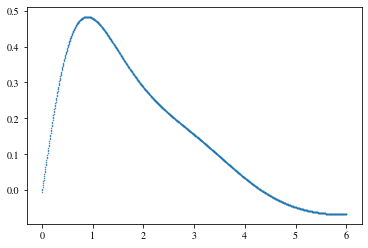

In [170]:
times = np.linspace(0., T, n)
plt.scatter(times,Result[N+3],s=0.2)

In [171]:
from numba import jit

@jit

def Sk(value):
    
    if value==0:  
        Sx=Result[0]
        for j in range(1,N):
            Sx=np.add(Sx,Result[j])
        return Sx/2
    elif value==1:
        Sy=Result[N]
        for j in range(1,N):
            Sy=np.add(Sy,Result[j+N])
        return Sy/2
    elif value==2:
        Sz=Result[2*N]
        for j in range(1,N):
            Sz=np.add(Sz,Result[j+2*N])
        return Sz/2
    


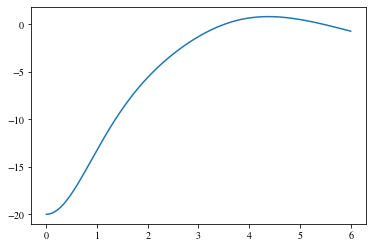

In [172]:
plt.plot(times,Sk(2))